# setup

In [1]:
import os, sys, json, math, random
from dataclasses import asdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset
from torch.optim import AdamW
from torch.cuda.amp import GradScaler

# --- project root & local modules ---
PROJ_ROOT = "/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation"
sys.path.append(os.path.join(PROJ_ROOT, "src"))

from otu_taxa.helpers_pretraining_model import MetricsLogger, set_seed, save_checkpoint, IGNORE_INDEX
from otu_taxa.trainer_hier_joint_unk import run_epoch

from otu_taxa.joint_hier_loss_metrics_unk import make_factorized_tax_loss_fn_fast_masked_with_unk
from otu_taxa.otu_taxa_transformer_unk import ModelConfig, OTUTaxaTransformerEmbedTaxTreeUnkTaxa
from otu_taxa.dataloaders_unk_balanced import (
    OTUTaxaDataset,
    MaskingConfig,
    make_collator_balanced,
    build_tax2ancestor_at_rank,
)



# data

In [2]:
# -----------------------------------
# Paths & configuration
# -----------------------------------
PROJ_ROOT = "/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation"

DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = "dataset_full_top999"

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_genus_silva_sintax",
    dataset_folder_name,
)

# Dataset artifacts
TAXONOMY_VOCAB_PATH = os.path.join(dataset_dir, "taxonomy_vocab.json")
path_to_taxonomy_tree = os.path.join(dataset_dir, "taxonomy_nested.json")
SAMPLES_JSONL = os.path.join(dataset_dir, "samples.jsonl")

# Tree artifacts
TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")


DESCENDANT_MATRIX_PATH = os.path.join(TREE_DIR, "descendant_matrix.npy")
UNK_VOCAB_PATH = os.path.join(TREE_DIR, "taxonomy_vocab_with_unk.json")
UNK_M_PATH = os.path.join(TREE_DIR, "descendant_matrix_with_unk.npy")
RANK_IDX_PATH = os.path.join(TREE_DIR, "rank_idx.npy")

# Output directory
run_name = "pretrain_hier_joint_unk_taxa"
out_dir = os.path.join(PROJ_ROOT, "runs_microbeatlas_genus_corruption", run_name)
os.makedirs(out_dir, exist_ok=True)


# -----------------------------------
# Metrics logger
# -----------------------------------
metrics_path = os.path.join(out_dir, "metrics.jsonl")
logger = MetricsLogger(metrics_path)

# -----------------------------------
# Taxonomy sizes
# -----------------------------------
with open(TAXONOMY_VOCAB_PATH, "r") as f:
    tax_vocab_real = json.load(f)
T_real = len(tax_vocab_real)
print("T_real:", T_real)

with open(UNK_VOCAB_PATH, "r") as f:
    tax_vocab_unk = json.load(f)
T_base = len(tax_vocab_unk)
print("T_base:", T_base)

# -----------------------------------
# Descendant matrices
# -----------------------------------
D_np_unk = np.load(UNK_M_PATH)
M_tensor = torch.from_numpy(D_np_unk)
print("Descendant matrix (with UNK):", M_tensor.shape)

D_np_real = np.load(DESCENDANT_MATRIX_PATH)
descendant_matrix_real = torch.from_numpy(D_np_real)
print("Descendant matrix (real only):", descendant_matrix_real.shape)

# -----------------------------------
# Rank index
# -----------------------------------
rank_idx = np.load(RANK_IDX_PATH)
print("rank_idx:", rank_idx.shape)


T_real: 6115
T_base: 6121
Descendant matrix (with UNK): torch.Size([6121, 6121])
Descendant matrix (real only): torch.Size([6115, 6115])
rank_idx: (6121,)


In [3]:

# def compute_length_percentiles(samples_jsonl_path, percentiles=(50, 75, 90, 95, 99, 99.9)):
#     lengths = []
#     with open(samples_jsonl_path, "r") as f:
#         for line in tqdm(f, desc="Reading sample lengths"):
#             if not line.strip():
#                 continue
#             rec = json.loads(line)
#             lengths.append(len(rec["otus"]))
#     lengths = np.asarray(lengths, dtype=np.int32)

#     out = {p: int(np.percentile(lengths, p)) for p in percentiles}
#     return out, lengths

# pct, lengths = compute_length_percentiles(SAMPLES_JSONL, percentiles=(90, 95, 99))
# print("Length percentiles:", pct)
# print("Max length:", int(lengths.max()))


In [4]:
# -----------------------------------
# Training hyperparameters
# -----------------------------------
seed = 123
device = "cuda" if torch.cuda.is_available() else "cpu"

epochs = 24
train_batch_size = int(32 * 2)
val_batch_size   = 64

max_len = 500                    # 96th percentile sequence length
mlm_prob = 0.15                  # masking rate
prob_joint, prob_otu_only, prob_tax_only = 0.50, 0.25, 0.25
keep_prob, random_prob = 0.10, 0.10


lr = 1e-3
weight_decay = 1e-3
warmup_ratio = 0.06
max_grad_norm = 1.0
grad_accum_steps = 2

num_workers = 0                  # 0 for determinism


In [5]:
# -----------------------------------
# Dataset splits
# -----------------------------------
set_seed(seed)
random.seed(seed)

ds = OTUTaxaDataset(dataset_dir)
N = len(ds)
print(f"[INFO] Dataset size: N={N}")

TEST_N = min(20_000, N)
VAL_N  = min(20_000, N - TEST_N)

all_idx = list(range(N))
random.shuffle(all_idx)

test_idx  = sorted(all_idx[:TEST_N])
val_idx   = sorted(all_idx[TEST_N:TEST_N + VAL_N])
train_idx = sorted(all_idx[TEST_N + VAL_N:])

print(
    f"[SPLIT] Train={len(train_idx)}  "
    f"Val={len(val_idx)}  "
    f"Test={len(test_idx)}  "
    f"(Total N={N})"
)

train_ds = Subset(ds, train_idx)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)

# -----------------------------------
# Collators
# -----------------------------------
train_cfg = MaskingConfig(
    mlm_prob=mlm_prob,
    prob_joint=prob_joint,
    prob_otu_only=prob_otu_only,
    prob_tax_only=prob_tax_only,
    max_len=max_len,
    keep_prob=keep_prob,
    random_prob=random_prob,
    balance_mode="otu",
)

train_collate = make_collator_balanced(
    dataset=ds,
    cfg=train_cfg,
)

val_cfg = MaskingConfig(
    mlm_prob=mlm_prob,
    prob_joint=prob_joint,
    prob_otu_only=prob_otu_only,
    prob_tax_only=prob_tax_only,
    max_len=max_len,
    keep_prob=keep_prob,
    random_prob=random_prob,
    balance_mode="none",
)

val_collate = make_collator_balanced(
    dataset=ds,
    cfg=val_cfg,
)

test_collate = make_collator_balanced(
    dataset=ds,
    cfg=val_cfg,
)

# -----------------------------------
# Data loaders
# -----------------------------------
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=train_collate,
    num_workers=num_workers,
    pin_memory=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    shuffle=False,
    collate_fn=val_collate,
    num_workers=0,
    pin_memory=True,
)

test_loader = DataLoader(
    test_ds,
    batch_size=val_batch_size,
    shuffle=False,
    collate_fn=test_collate,
    num_workers=0,
    pin_memory=True,
)

# -----------------------------------
# Model sizes and special token indices
# -----------------------------------
n_otus = ds.O + 2
pad_otu_id = ds.O

n_taxa = T_base + 2
pad_tax_id  = T_base
mask_tax_id = T_base + 1


[INFO] Dataset size: N=1836250
[SPLIT] Train=1796250  Val=20000  Test=20000  (Total N=1836250)


# Load model

In [ ]:
# -----------------------------
# Model configuration
# -----------------------------
model_cfg = ModelConfig(
    d_model=256,
    n_layers=6,
    n_heads=4,
    d_ff=1024,
    dropout=0.1,
    activation="gelu",
    tie_otu_weights=True,
    otu_loss_weight=1.0,
    tax_loss_weight=1.0,
    emb_dropout=0.1,
    layernorm_emb=True,
    T_real=T_real,
)

# -----------------------------
# Hierarchical taxonomy loss
# -----------------------------
def build_rank_idx_from_vocab(vocab_list):
    rank_map = {'k': 0, 'p': 1, 'c': 2, 'o': 3, 'f': 4, 'g': 5, 's': 6}
    out = []
    for name in vocab_list:
        ch = name[0].lower()
        out.append(rank_map.get(ch, -1))
    return torch.tensor(out, dtype=torch.long)

rank_idx = build_rank_idx_from_vocab(tax_vocab_unk)

hier_tax_loss_fn = make_factorized_tax_loss_fn_fast_masked_with_unk(
    M_tensor=M_tensor,
    rank_idx=rank_idx,
    tax_vocab=tax_vocab_unk,
    T_base=T_base,
)

# -----------------------------
# Model initialization
# -----------------------------
model = OTUTaxaTransformerEmbedTaxTreeUnkTaxa(
    n_otus=n_otus,
    n_taxa=n_taxa,
    pad_otu_id=pad_otu_id,
    pad_tax_id=pad_tax_id,
    config=model_cfg,
    tax_loss_fn=hier_tax_loss_fn,
).to(device)

# -----------------------------
# Optimizer and scheduler
# -----------------------------
optimizer = AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)

steps_per_epoch = math.ceil(len(train_loader) / max(1, grad_accum_steps))
total_steps = steps_per_epoch * epochs
warmup_steps = max(1, int(warmup_ratio * total_steps))

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return max(
        0.0,
        float(total_steps - current_step)
        / float(max(1, total_steps - warmup_steps)),
    )

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda,
)

scaler = GradScaler(enabled=(device == "cuda"))

# -----------------------------
# Run metadata
# -----------------------------
run_meta = {
    "seed": seed,
    "epochs": epochs,
    "train_batch_size": train_batch_size,
    "val_batch_size": val_batch_size,
    "max_len": max_len,
    "mlm_prob": mlm_prob,
    "prob_split": [prob_joint, prob_otu_only, prob_tax_only],
    "optimizer": {
        "lr": lr,
        "weight_decay": weight_decay,
    },
    "sched": {
        "warmup_ratio": warmup_ratio,
        "total_steps": total_steps,
        "warmup_steps": warmup_steps,
    },
    "model_cfg": asdict(model_cfg),
    "dataset": {
        "N": N,
        "N_train": len(train_ds),
        "N_val": len(val_ds),
        "O": ds.O,
        "T_real": T_real,
        "T_base": T_base,
    },
}

with open(os.path.join(out_dir, "meta.json"), "w") as f:
    json.dump(run_meta, f, indent=2)

print(
    f"[INFO] Train={len(train_ds)}  "
    f"Val={len(val_ds)}  "
    f"Steps/epoch={steps_per_epoch}  "
    f"Total steps={total_steps}"
)


UNK ids per rank: [6114, 6115, 6116, 6117, 6118, 6119, 6120]


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[INFO] Train=1796250  Val=20000  Steps/epoch=14034  Total steps=336816


# training model

In [7]:
rank_map = {'k':0, 'p':1, 'c':2, 'o':3, 'f':4, 'g':5, 's':6}
unk_ids_by_rank = {}

for idx, token in enumerate(tax_vocab_unk):
    # Expect tokens like "k:UNK", "p:UNK", ..., "s:UNK"
    # Adjust this condition if your naming is slightly different.
    if token.endswith("UNK") or token.endswith("unk"):
        prefix = token.split(":")[0]  # 'k','p',...,'s'
        if prefix in rank_map:
            r = rank_map[prefix]
            unk_ids_by_rank[r] = idx

print("UNK IDs per rank:", unk_ids_by_rank)
print("T_base:", T_base)

UNK IDs per rank: {0: 6114, 1: 6115, 2: 6116, 3: 6117, 4: 6118, 5: 6119, 6: 6120}
T_base: 6121


In [8]:
best_val = float("inf")
global_step = 0

for epoch in range(1, epochs + 1):

    # ---- TRAIN ----
    train_stats, global_step = run_epoch(
        model=model,
        dataloader=train_loader,
        device=device,
        IGNORE_INDEX=IGNORE_INDEX,
        split="train",
        epoch=epoch,
        global_step=global_step,
        M_tensor=M_tensor,
        rank_idx=rank_idx,
        T_base=T_base,
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        grad_accum_steps=grad_accum_steps,
        max_grad_norm=max_grad_norm,
        logger=logger,
        deterministic_masks=False,
        metric_every_steps=1000,
        train_metric_max_positions=2000,
        progress_every_steps=50,
    )

    # ---- VALIDATION ----
    val_stats, _ = run_epoch(
        model=model,
        dataloader=val_loader,
        device=device,
        IGNORE_INDEX=IGNORE_INDEX,
        split="val",
        epoch=epoch,
        global_step=global_step,
        M_tensor=M_tensor,
        rank_idx=rank_idx,
        T_base=T_base,
        optimizer=None,
        scheduler=None,
        scaler=None,
        grad_accum_steps=1,
        max_grad_norm=max_grad_norm,
        logger=logger,
        deterministic_masks=True,
        progress_every_steps=0,
    )

    if val_stats["loss"] < best_val:
        best_val = val_stats["loss"]
        save_checkpoint(
            os.path.join(out_dir, "best.pt"),
            model,
            optimizer,
            scheduler,
            scaler,
            epoch,
            global_step,
            best_val,
        )
        print(f"[E{epoch:02d}] Saved BEST")

save_checkpoint(
    os.path.join(out_dir, "last.pt"),
    model,
    optimizer,
    scheduler,
    scaler,
    epoch,
    global_step,
    best_val,
)


[OTUTaxaTransformerEmbedTaxTree] using otu_loss_fn=default_otu_loss_fn (id=134766214193936) kwargs=['attention_mask', 'ignore_index']
[OTUTaxaTransformerEmbedTaxTree] using tax_loss_fn=loss_fn (id=134768782122288) kwargs=['ignore_index']
[OTUTaxaTransformerEmbedTaxTree] using combine_loss_fn=default_combine_loss_fn (id=134766214193648) kwargs=[]


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[E01] TRAIN global_step=50 batch=100
[E01] TRAIN global_step=100 batch=200
[E01] TRAIN global_step=150 batch=300
[E01] TRAIN global_step=200 batch=400
[E01] TRAIN global_step=250 batch=500
[E01] TRAIN global_step=300 batch=600
[E01] TRAIN global_step=350 batch=700
[E01] TRAIN global_step=400 batch=800
[E01] TRAIN global_step=450 batch=900
[E01] TRAIN global_step=500 batch=1000
[E01] TRAIN global_step=550 batch=1100
[E01] TRAIN global_step=600 batch=1200
[E01] TRAIN global_step=650 batch=1300
[E01] TRAIN global_step=700 batch=1400
[E01] TRAIN global_step=750 batch=1500
[E01] TRAIN global_step=800 batch=1600
[E01] TRAIN global_step=850 batch=1700
[E01] TRAIN global_step=900 batch=1800
[E01] TRAIN global_step=950 batch=1900
[E01] TRAIN global_step=1000 batch=2000
[E01] TRAIN global_step=1050 batch=2100
[E01] TRAIN global_step=1100 batch=2200
[E01] TRAIN global_step=1150 batch=2300
[E01] TRAIN global_step=1200 batch=2400
[E01] TRAIN global_step=1250 batch=2500
[E01] TRAIN global_step=1300 

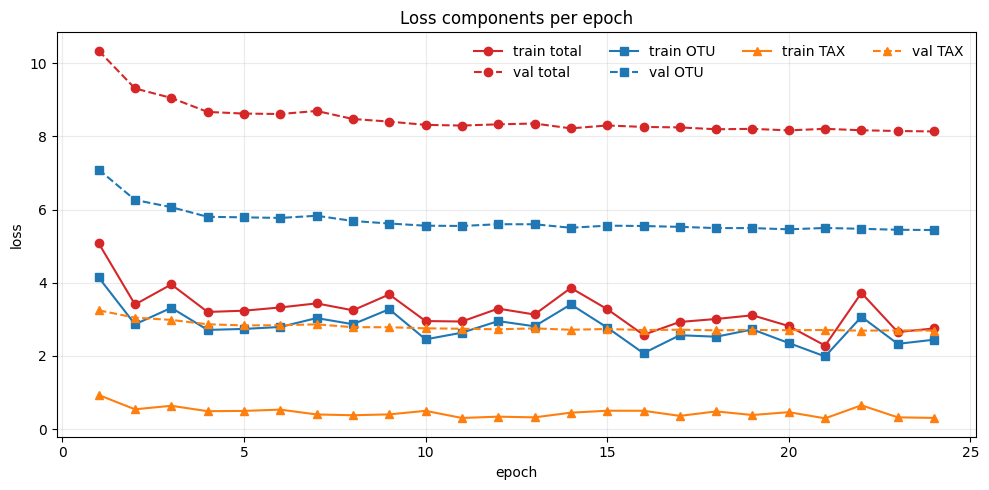

In [11]:

# ======== CONFIG ========
metrics_path = os.path.join(out_dir, "metrics.jsonl")  # your run folder
# =========================

# --- load and tidy ---
rows = [json.loads(l) for l in open(metrics_path) if l.strip()]
df = pd.DataFrame(rows).sort_values(["epoch", "step"], ignore_index=True)

train_ep = df[df["split"] == "train_epoch"].copy()
val_ep   = df[df["split"] == "val_epoch"].copy()

# --- colors ---
c_total, c_otu, c_tax, c_tree = "C3", "C0", "C1", "C2"

fig, ax = plt.subplots(figsize=(10, 5))

# --- total loss ---
if "loss" in train_ep.columns and "loss" in val_ep.columns:
    ax.plot(train_ep["epoch"], train_ep["loss"], "o-",  color=c_total, label="train total")
    ax.plot(val_ep["epoch"],   val_ep["loss"],   "o--", color=c_total, label="val total")

# --- OTU / TAX losses ---
if {"loss_otu","loss_tax"}.issubset(train_ep.columns) and {"loss_otu","loss_tax"}.issubset(val_ep.columns):
    ax.plot(train_ep["epoch"], train_ep["loss_otu"], "s-",  color=c_otu, label="train OTU")
    ax.plot(val_ep["epoch"],   val_ep["loss_otu"],   "s--", color=c_otu, label="val OTU")
    ax.plot(train_ep["epoch"], train_ep["loss_tax"], "^-",  color=c_tax, label="train TAX")
    ax.plot(val_ep["epoch"],   val_ep["loss_tax"],   "^--", color=c_tax, label="val TAX")

# # --- Tree loss (optional) ---
# if "loss_tree" in train_ep.columns and "loss_tree" in val_ep.columns:
#     ax.plot(train_ep["epoch"], 10*train_ep["loss_tree"], "d-",  color=c_tree, label="train TREE")
#     ax.plot(val_ep["epoch"],   10*val_ep["loss_tree"],   "d--", color=c_tree, label="val TREE")

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("Loss components per epoch")
ax.grid(alpha=0.25)
ax.legend(ncol=4, loc="upper right", frameon=False)
plt.tight_layout()
plt.show()


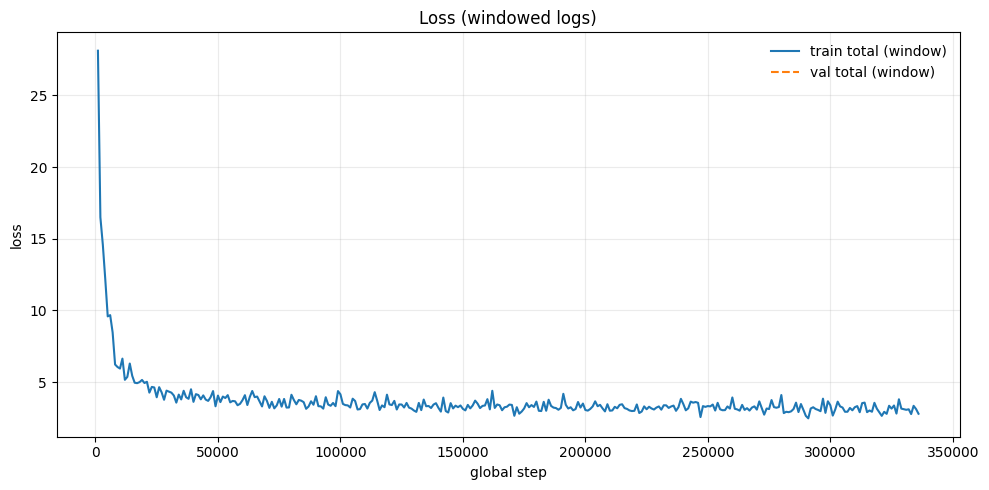

In [12]:
train_st = df[df["split"] == "train_step"].copy()
val_st   = df[df["split"] == "val_step"].copy()

fig, ax = plt.subplots(figsize=(10, 5))

if "loss" in train_st.columns:
    ax.plot(train_st["step"], train_st["loss"], "-", label="train total (window)")
if "loss" in val_st.columns:
    ax.plot(val_st["step"], val_st["loss"], "--", label="val total (window)")

ax.set_xlabel("global step")
ax.set_ylabel("loss")
ax.set_title("Loss (windowed logs)")
ax.grid(alpha=0.25)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()
